<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Selecting-useful-features" data-toc-modified-id="Selecting-useful-features-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Selecting useful features</a></span></li><li><span><a href="#Validating-that-features-are-useful" data-toc-modified-id="Validating-that-features-are-useful-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Validating that features are useful</a></span></li><li><span><a href="#Comparing-predictions-to-data" data-toc-modified-id="Comparing-predictions-to-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparing predictions to data</a></span></li><li><span><a href="#Running-Inference" data-toc-modified-id="Running-Inference-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Running Inference</a></span></li></ul></div>

# Selecting useful features

When looking at the second model's feature importances, we saw that the TF-IDF vectorization features were suspiciously absent from the most important features we displayed. To verify that a model can perform well without these features, let's omit them and train a third model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
# import joblib
from sklearn.externals import joblib

import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
from ml_editor.ch4_data_processing import (format_raw_df, 
                                           get_split_by_author)

In [3]:
from ml_editor.ch7_model_v2 import (add_char_count_features, get_word_stats,
                                    get_sentiment_score, POS_NAMES,
                                    get_question_score_from_input)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Vidya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
from ml_editor.ch5_model_evaluation import (get_feature_importance,
                                            get_roc_plot,
                                            get_confusion_matrix_plot,
                                            get_calibration_plot)

In [5]:
%load_ext autoreload
%autoreload 2
np.random.seed(35)

In [6]:
data_path = Path('../raw_data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())
df = df.loc[df['is_question']].copy()

In [7]:
df['full_text'] = df['Title'].str.cat(df['body_text'], sep=' ', na_rep='')

In [8]:
# Check out the ml_editor source code to see more about what these functions are doing!

df = add_char_count_features(df.copy())
df = get_word_stats(df.copy())
df = get_sentiment_score(df.copy())

100%|███████████████████████████████████████████████████████████████████████████| 10255/10255 [00:16<00:00, 606.05it/s]


In [9]:
feature_arr = [
    'num_questions', 'num_periods', 'num_commas', 'num_exclam', 'num_quotes',
    'num_colon', 'num_stops', 'num_semicolon', 'num_words', 'num_chars',
    'num_diff_words', 'avg_word_len', 'polarity'
]
feature_arr.extend(POS_NAMES.keys())

Now that we've added new features, let's train a new model. We'll use the same model as before, only the features are different.

In [10]:
# We split again since we have now added all features.
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [11]:
df[feature_arr].head()*100

,num_questions,num_periods,num_commas,num_exclam,num_quotes,num_colon,num_stops,num_semicolon,num_words,num_chars,...,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X
Id,,,,,,,,,,,,,,,,,,,,,
1,56.818182,56.818182,28.409091,0.0,0.000000,0.000000,1022.727273,0.0,2073.863636,35200,...,3.409091,0.000000,1.136364,2.272727,0.000000,1.988636,0.000000,0.00000,3.409091,0.000000
2,90.634441,30.211480,60.422961,0.0,60.422961,0.000000,1087.613293,0.0,2024.169184,33100,...,4.229607,0.000000,0.000000,1.510574,0.000000,2.416918,0.302115,0.00000,1.510574,0.000000
3,175.438596,87.719298,87.719298,0.0,0.000000,0.000000,1491.228070,0.0,2719.298246,11400,...,2.631579,0.877193,0.000000,5.263158,0.000000,3.508772,0.000000,0.00000,5.263158,0.000000
5,22.779043,68.337130,91.116173,0.0,0.000000,11.389522,1184.510251,0.0,2209.567198,87800,...,3.530752,0.000000,0.797267,1.480638,0.000000,2.050114,0.683371,0.22779,3.302961,0.113895
7,135.135135,67.567568,67.567568,0.0,0.000000,0.000000,945.945946,0.0,2027.027027,14800,...,2.027027,0.000000,0.000000,2.702703,1.351351,2.702703,0.675676,0.00000,1.351351,0.000000


In [12]:
def get_feature_vector_and_label(df, feature_names):
    """
    Generate input and output vectors using the vectors feature and
     the given feature names
    :param df: input DataFrame
    :param feature_names: names of feature columns (other than vectors)
    :return: feature array and label array
    """
    
    features = df[feature_names].astype(float)
    labels = df['Score'] > df['Score'].median()
    return features, labels

In [13]:
X_train, y_train = get_feature_vector_and_label(train_df, feature_arr)
X_test, y_test = get_feature_vector_and_label(test_df, feature_arr)

In [14]:
y_train.value_counts()

False    4594
True     3761
Name: Score, dtype: int64

In [15]:
X_test.shape

(1900, 30)

In [16]:
clf = RandomForestClassifier(n_estimators=100,
                             class_weight='balanced',
                             oob_score=True)
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

Now, we can measure performance as we saw in the first training notebook.

In [17]:
def get_metrics(y_test, y_predicted):
    # true positives / (true positives+false positives)
    precision = precision_score(y_test,
                                y_predicted,
                                pos_label=True,
                                average='binary')

    # true positives / (true positives + false negatives)
    recall = recall_score(y_test,
                          y_predicted,
                          pos_label=True,
                          average='binary')

    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=True, average='binary')

    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1


# Training accuracy
# Thanks to https://datascience.stackexchange.com/questions/13151/randomforestclassifier-oob-scoring-method
y_train_pred = np.argmax(clf.oob_decision_function_, axis=1)
accuracy, precision, recall, f1 = get_metrics(y_train, y_train_pred)

print('Training accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f' %
      (accuracy, precision, recall, f1))

Training accuracy = 0.578, precision = 0.543, recall = 0.391, f1 = 0.455


In [18]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print(
    'Validation accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f' %
    (accuracy, precision, recall, f1))

Validation accuracy = 0.571, precision = 0.544, recall = 0.408, f1 = 0.466


Let's save our new model and vectorizer to disk so we can use them later.

In [19]:
model_path = Path("../models/model_3.pkl")
joblib.dump(clf, model_path)

['..\\models\\model_3.pkl']

# Validating that features are useful

Next, we'll use the method described in the [feature importance notebook](ch_5_4_feature_importance.ipynb
) to validate that our new features are being used by the new model.


In [20]:
all_feature_names = np.array(feature_arr)

In [21]:
k = 20
print('Top %s importances \n ' % k)
print('\n'.join([
    '%s: %.2g' % (tup[0], tup[1])
    for tup in get_feature_importance(clf, all_feature_names)[:k]
]))

Top 20 importances 
 
num_chars: 0.049
num_periods: 0.048
num_questions: 0.047
num_diff_words: 0.047
ADV: 0.045
DET: 0.045
ADP: 0.043
ADJ: 0.043
num_commas: 0.042
PUNCT: 0.042
NOUN: 0.042
AUX: 0.042
PART: 0.041
polarity: 0.041
PRON: 0.04
num_stops: 0.04
num_words: 0.04
VERB: 0.04
SCONJ: 0.038
avg_word_len: 0.038


In [22]:
print('Bottom %s importances \n ' % k)
print('\n'.join([
    '%s: %.2g' % (tup[0], tup[1])
    for tup in get_feature_importance(clf, all_feature_names)[-k:]
]))

Bottom 20 importances 
 
NOUN: 0.042
AUX: 0.042
PART: 0.041
polarity: 0.041
PRON: 0.04
num_stops: 0.04
num_words: 0.04
VERB: 0.04
SCONJ: 0.038
avg_word_len: 0.038
PROPN: 0.031
NUM: 0.026
num_colon: 0.02
num_quotes: 0.019
SYM: 0.014
INTJ: 0.013
X: 0.0096
num_exclam: 0.0069
num_semicolon: 0.0069
CONJ: 0


Our new features are amongst the most predictive! On the flip side, we can see that the word vectors from the TF-IDF vectorization approach don't seem to be particularly helpful. In a [following notebook](ch_7_2_third_model), we will train a third model without these features and see how well it performs.

# Comparing predictions to data

This section uses the evaluation methods described in the [Comparing Data To Predictions notebook](ch_5_2_comparing_data_to_predictions), but on our new model.

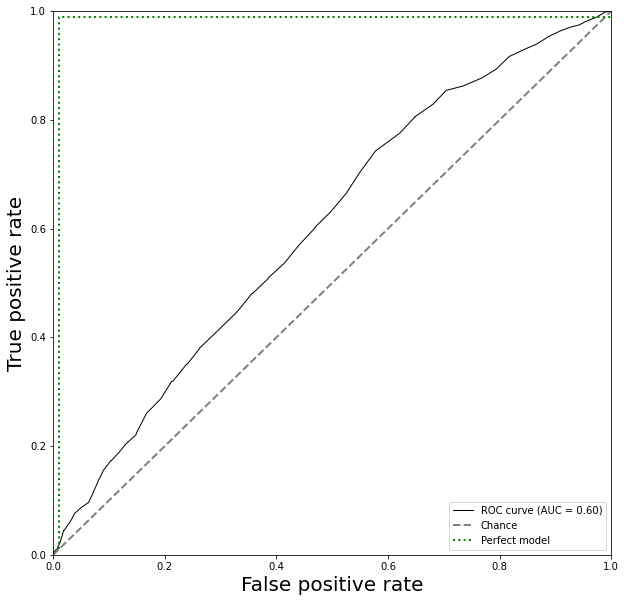

In [23]:
get_roc_plot(y_predicted_proba[:, 1], y_test, figsize=(10, 10))

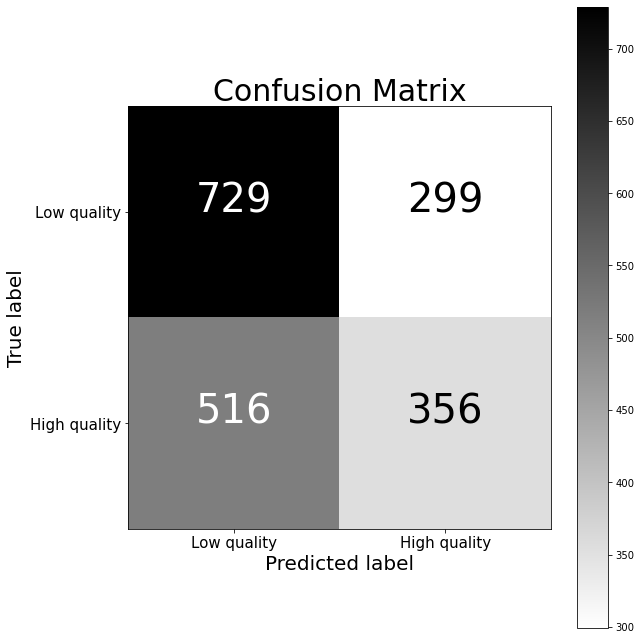

In [24]:
get_confusion_matrix_plot(y_predicted, y_test, figsize=(9, 9))

No handles with labels found to put in legend.


	Brier: 0.241 


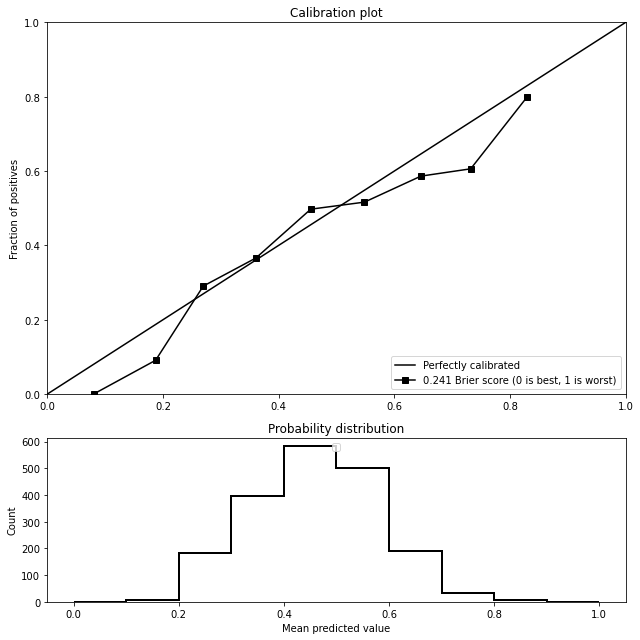

In [25]:
get_calibration_plot(y_predicted_proba[:, 1], y_test, figsize=(9, 9))

This third model only uses features that can be easily interpreted, and is better calibrated than previous models. This makes it a very good candidate for our application (feel free to look at Comparing Models for a more detailed comparison).

# Running Inference
Just like for our first two models, we define an inference function that takes in an arbitrary question and outputs an estimated probability of it receiving a high score according to our model.

In [27]:
pos_prob = get_question_score_from_input('''
When quoting a person's informal speech, how much liberty do you have to make changes to what they say?
''')

print(
    '%s probability of the question receiving a high score according to our model'
    % (pos_prob))

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 985.74it/s]

0.29 probability of the question receiving a high score according to our model
